In [1]:
%matplotlib inline

In [2]:
import numpy as np
import PIL.Image as image

# Project includes.
import hashes

# Perlin noise
## Origin. Application. Implementation. Demonstration.
## Author: Mihail Milev

### Abstract

Perlin noise is a widely adopted algorithm in a lot of areas of computer science. It generates coherent sequences of random numbers that when used in graphics look fluent, natural and pleasing to humans.

The aim of this work is to find out what math concepts the algorithm is based on and how they work together. The gathered knowledge is then used to actually implement it in the Python programming language.

Our investigations end with a few example applications of the algorithm including generating an image with moving clouds and proposing ideas for future work. 

### What is noise

Any sequence of random values is considered noise. While learning a programming language developers are introduced to random number generators at some point. Either for creating test data for an algorithm or graphics for presentations - they are useful without any doubt. Random numbers have one big flaw though - when visualized they look very unnatural to people because values "jump" with big gaps. The problem is that each number has been generated in a silo - with no relation to the surrounding numbers.

![](img/random-noise.gif)

### What is Perlin noise

Perlin noise is an extremely powerful algorithm that is addressing the noise problem by generating a fluent sequence of random numbers. Ken Perlin developed it while working on the original Tron movie in the early 1980s. He used it to create procedural textures for computer-generated effects. In 1997, Perlin won an Academy Award in technical achievement for this work. [2]

![](img/perlin-noise.gif)

### Where is it being used

Perlin noise can be used for any sort of wave-like material or texture. For example, it could be used for procedural terrain, fire effects, water and clouds. These effects mostly represent Perlin noise in the 2nd and 3rd dimensions, but it can be extended into the 4th dimension rather trivially. Additionally Perlin noise can be used in only 1 dimension for purposes such as side-scrolling terrain or to create the illusion of handwritten lines.

Also, if you extend Perlin noise into an additional dimension and consider the extra dimension as time, you can animate it. For example, 2D Perlin noise can be interpreted as terrain, but 3D noise can similarly be interpreted as undulating waves in an ocean scene. [1]

![](img/perlin-water.jpg)
![](img/perlin-fire.jpg)

### What concepts is it based on

The Perlin noise algorithm can be implemented as a simple noise function receiving n float number parameters for each dimension of interest (yes - any dimension can be implemented but the algorithm slows down a lot for many dimensions). The result of the function is a number between [-1,1] but it can be translated to a number between [0,1] for convenience (e.g. 0 to 1 can be interpreted as 0% to 100% and easily mapped to anything - a color, a choice of tiles on a map, etc.).

The main concepts the algorithm is based on are the following:

* **A coordinate system** - we split each dimension in sections where each section starts from an integer and ends on the next integer. If we take 2D space for example - this is a grid with lines on integer values - 0, 1, 2, etc. When the noise function is called the algorithm finds the section the arguments are located in and strips their whole parts to find their coordinates inside the section.


* **[Dot product](https://en.wikipedia.org/wiki/Dot_product) of a pseudorandom gradient vector and a distance vector** - for each section boundary point we choose a random vector - the gradient vector. An important rule is that we use the same gradient vector for each boundary point on consecutive noise calculations (we will use a hash function to guarantee that but more on this later). This way the algorithm can return the same result between multiple calls. In 2D space this may look something like this:

    ![](img/gradient-vectors.png)

    Afterwards we define the distance vectors - those are the vectors starting from the section boundary points and ending at the point we received as arguments in the function. Again in 2D space:

    ![](img/distance-vectors.png)
    
    When we have all of those vectors we can use their [dot products](https://en.wikipedia.org/wiki/Dot_product) to calculate the influence - the number that will allow us to transition smoothly between points. As we know calculating the dot product between two vectors means summing the multiplcations of each dimension:
    
    $$ (a, b) · (c, d) = ac + bd $$
    
    
* **Linear interpolation** - once we have calculated the dot products for all vectors in a section (4 in 2D space, 8 in 3D space) we apply linear interpolation to calculate a weighted average for the final result. The formula to apply is:

    $$ a + x (b - a) $$
    
    Where $ a $ and $ b $ are the dot product influence for 2 boundary points in a single dimension and $ x $ is the fraction of the noise function argument value in the same dimension.

    We interpolate each dimension separately until we get to the point we received as arguments.


* **Fading function** - we apply this function to the arguments we receive to make transitions smoother. In essence the fading makes values close to 0 and 1 change slowly and values near 0.5 change fast.

    ![](img/fade-curve.gif)

    An interesting fact is that the initial Perlin noise algorithm used the following fading function:
    
    $$ 3t^2 - 2t^3 $$
    
    The problem with this fading function is described in detail in [3]. In short - it breaks the smoothness in certain cases. That's why Ken Perlin created an improved version of his algorithm to fix it. The improved fading function is:
    
    $$ 6t^5 - 15t^4 + 10t^3 $$

### Implementation - let's get our hands dirty

We will start with defining various independent pieces of the algorithm that we will use in the noise function itself.

Here are 3 fading functions we will play with in the examples - no fade, the initial fade and the improved fade.

In [15]:
def no_fade(t):
    """
    No fade means just return t (the number) as it is.
    """
    return t

def initial_fade(t):
    """
    The initial fade.
    """
    return 3 * t ** 2 - 2 * t ** 3

def improved_fade(t):
    """
    The improved fade.
    """
    return 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3

We will need also linear interpolation - let's define it as a separate function since it's just a simple formula.

In [4]:
def lerp(x, a, b):
    """
    Calculates the linear interpolation of x between a and b.
    """
    return a + x * (b - a)

Now things will get a bit more complex... As we've mentioned before we will use a hashing function to choose a gradient vector for each section boundary point. A hash function, as defined by wikipedia, is:

    …any function that can be used to map data of arbitrary size to data of fixed size, with slight differences in input
    data producing very big differences in output data. [1]
    
The key here is - if we have a set of coordinates for a boundary point, let's say x and y, the hash function for them will ALWAYS return the same value. It will not matter if we call the noise function with the same parameters once or 100 times - the result will be the same.

For convenience and speed we will not use a hashing algorithm but a simple list of predefined values from 0 - 255 instead (located in the external hashes.py file). What this also means is that each section will be actually split in 256 small pieces. To prevent overflows while picking from our list we will just double it.

In [5]:
p = hashes.default + hashes.default

def get_hash(x, y, z):
    """
    Picks a random hash value for a set of coordinates.
    """
    return p[p[p[x] + y] + z]

We will also need a function that will calculate the dot product of a pseudorandom gradient vector (a hash we've chosen) and a distance vector. Here is my interpretation so it is easier to read. You can still check [5] for the function in the improved Perlin noise algorithm and [6] for the faster implementation. The name grad() is kept from the original algorithm for consistency.

In [6]:
def grad(rand, x, y, z):
    """
    Calculates the influence of a gradient vector and a distance vector.
    """
    group = rand & 15
    group_results = (
        x + y,
        -x + y,
        x - y,
        -x - y,
        x + z,
        -x + z,
        x - z,
        -x - z,
        y + z,
        -y + z,
        y - z,
        -y - z,
        y + x,
        -y + z,
        y - x,
        -y - z
    )
    return group_results[group]

And... we're almost there. The only thing left is to actually combine those pieces with some logic and we'll have a Perlin noise implementation. Read the comments for explanations on each line.

In [7]:
def noise(x, y, z, fader=improved_fade):
    """
    Perlin noise implementation. Supports 3 dimensions.
    Pass a custom fader to play with the smoothness of the result.
    """
    # Find the bottom left point of the section our point is in.
    # We will use a section size of 256 since our hash function produces results of this size.
    # & 255 is the same as % 256 - just faster.
    # g comes from grid.
    xg = int(x) & 255
    yg = int(y) & 255
    zg = int(z) & 255
    
    # Calculate the coordinates of our point of interest inside the section.
    # The results will be numbers between (0,1).
    x = x - int(x)
    y = y - int(y)
    z = z - int(z)
    
    # Calculate the fade curves for all dimensions in the section.
    # This will introduce smoothness.
    u = fader(x)
    v = fader(y)
    w = fader(z)
    
    # Pick a gradient vector for each of the section boundary points - 8 in 3D space.
    aaa = get_hash(xg, yg, zg)
    aba = get_hash(xg, yg + 1, zg)
    aab = get_hash(xg, yg, zg + 1)
    abb = get_hash(xg, yg + 1, zg + 1)
    baa = get_hash(xg + 1, yg, zg)
    bba = get_hash(xg + 1, yg + 1, zg)
    bab = get_hash(xg + 1, yg, zg + 1)
    bbb = get_hash(xg + 1, yg + 1, zg + 1)
    
    # Calculate the weighted averages of the influences (dot products) via linear interpolation.
    # Do it for the "front-bottom horizontal line" first.
    x1 = lerp(
        u,
        grad(aaa, x, y, z),
        grad(baa, x - 1, y, z)
    )
    
    # Then for the "front-top horizontal line".
    x2 = lerp(
        u,
        grad(aba, x, y - 1, z),
        grad(bba, x - 1, y - 1, z)
    )
    
    # Then for the "front vertical line".
    y1 = lerp(v, x1, x2)

    # Then for the "back-bottom horizontal line".
    x1 = lerp(
        u,
        grad(aab, x, y, z - 1),
        grad(bab, x - 1, y, z - 1)
    )
    
    # Then for the "back-top horizontal line".
    x2 = lerp(
        u,
        grad(abb, x, y - 1, z - 1),
        grad(bbb, x - 1, y - 1, z - 1)
    )
    
    # Then for the "back vertical line".
    y2 = lerp(v, x1, x2);
    
    # Then for the argument point itself.
    original_result = lerp(w, y1, y2)
    
    # Now we do another average to return results from 0 to 1 instead of -1 to 1.
    return (original_result + 1) / 2;

### Examples - let's play

But before showing some stuff - let's define some tools we'll need.

Here is a function that will create a 2D matrix of color noise values (integers from 0 to 255) with certain size and fader.

In [8]:
def make_color_noises(width, height, fader=improved_fade):
    """
    Generates a 2D matrix of random colors.
    """
    noises = np.zeros((height, width), dtype=int)
    for column in range(width):
        for row in range(height):
            noises[row][column] = int(noise(column / 10, row / 10, 0.2, fader=fader) * 255)
    return noises

Here is a function that will create a PIL image from a 2D matrix of color noise values and will apply a custom coloring function so we can modify the output for each pixel.

In [9]:
def get_image(noises, tile=1, color=lambda x: (x, x, x)):
    """
    Generates a PIL image instance from a 2D matrix of perlin noise values.
    
    The tile parameter sets the repetition of each noise value so you can zoom in.
    For example if tile=3, instead of coloring a single pixel, a value will color a square with a size of 3x3.
    
    Use the color parameter to pass a function that returns a tuple of RGB colors to manipulate the output.
    """
    h, w = noises.shape 
    end_w, end_h = w * tile, h * tile
    img = image.new('RGB', (end_w, end_h))
    for column in range(end_w):
        for row in range(end_h):
            value = int(noises[int(np.floor(row / tile)), int(np.floor(column / tile))])
            img.putpixel((column, row), color(value))
    return img

**Example 1** - compare the 3 fade functions

No fade

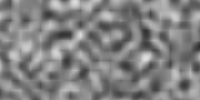

In [10]:
noises = make_color_noises(200, 100, fader=no_fade)
get_image(noises)

Initial fade

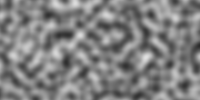

In [11]:
noises = make_color_noises(200, 100, fader=initial_fade)
get_image(noises)

Improved fade

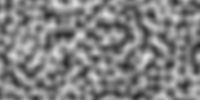

In [12]:
noises = make_color_noises(200, 100, fader=improved_fade)
get_image(noises)

**Example 2** - create clouds

That should be pretty easy with our color parameter on the get_image function (it's great when we build reusable tools!). We just have to always set Blue to 255 and voala.

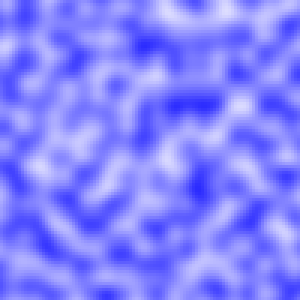

In [13]:
noises = make_color_noises(100, 100)
get_image(noises, tile=3, color=lambda x: (x, x, 255))

**Example 3** - make the clouds move

We will create a sequence of images and combine them into a gif file to have moving clouds - sounds simple right? But how are we going to make the clouds move? The complex answer could be use the 3rd dimension as time but I will leave that as future work. Let's do some numpy array juggling!

In [14]:
# Generate a big set of noises - a small trick of ours.
all_noises = make_color_noises(300, 300)

# Now generate the cloud images - each next will use a small window of all cloud noises.
clouds = []
cloud_w, cloud_h = 30, 30
for indent in range(256):
    cloud_noises = all_noises[indent:indent + cloud_w, indent:indent + cloud_h]
    clouds.append(get_image(cloud_noises, tile=3, color=lambda x: (x, x, 255)))

# Save it to disk... Unfortunately Jupyter notebook is not that good at rendering and NOT caching gifs.
clouds[0].save('clouds.gif', save_all=True, append_images=clouds[1:], duration=1, loop=0)

![](clouds-30-30.gif)

### Conclusion

We got familiar with what are noise and Perlin noise - their commonalities and differences. We saw that Perlin noise actually has a lot of applications on many levels.

Then we deep dived into the math concepts the algorithm is based on to understand how it works under the hood. Perlin noise is a great example how a few simple math concepts, when applied properly, can lead to awesome results.

Afterwards we implemented the algorithm itself in small steps and actually saw why it is so widely used - the output of the algorithm creates fluent sequences of random numbers between 0 and 1 (or -1 and 1) which can be applied to ANY context. Imagination is literally the limit!

In the end we had some time for fun too - we generated some boring greyscale images to compare different fading functions but then played around with some clouds.

### Future work

* Try applying the binary dot product calculations from [6] and measure the performance gains / losses.
* Use the 3rd dimension to animate the clouds.
* Find out what coloring modifications must be applied to generate water and fire.
* Play around with a set of terrain tiles to generate a map.

### References

[1] [Flafla2, 2014, Understanding Perlin Noise](http://flafla2.github.io/2014/08/09/perlinnoise.html)

[2] [Khan Academy, Perlin noise](https://www.khanacademy.org/computing/computer-programming/programming-natural-simulations/programming-noise/a/perlin-noise)

[3] [Lars Huttar, 2017, Learning how Perlin noise works](http://www.huttar.net/lars-kathy/graphics/perlin-noise/perlin-noise.html)

[4] [Matt Zucker, 2001, Perlin noise math FAQ (initial implementation)](https://mzucker.github.io/html/perlin-noise-math-faq.html)

[5] [Ken Perlin, 2002, Improved noise reference implementation](https://mrl.nyu.edu/~perlin/noise/)

[6] [Riven, 2010, Calculate PerlinNoise faster with an optimization to grad()](http://riven8192.blogspot.bg/2010/08/calculate-perlinnoise-twice-as-fast.html)